In [1]:
from sklearn.model_selection import train_test_split
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
import tensorflow as tf
import pandas as pd
import json
import gc
from tqdm import tqdm

/media/soroush/Partition 3/Email-Classification/.emailvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 08:50:49.675973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 08:50:49.779510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736754649.813501    6057 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736754649.823674

In [2]:
print(transformers.__version__)

4.48.0


In [ ]:
# import re
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stopw = stopwords.words('english')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

In [4]:
root_path = '../bbc-text.csv'

In [5]:
df = pd.read_csv(root_path)
df.head()


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.shape

(2225, 2)

In [6]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [7]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,encoded_text
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1
5,politics,howard hits back at mongrel jibe michael howar...,2
6,politics,blair prepares to name poll date tony blair is...,2
7,sport,henman hopes ended in dubai third seed tim hen...,3
8,sport,wilkinson fit to face edinburgh england captai...,3
9,entertainment,last star wars not for children the sixth an...,1


### Fine-tuning

In [8]:
from transformers import TFDistilBertForSequenceClassification, AutoTokenizer 
import tensorflow as tf

In [9]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

W0000 00:00:1736754673.343527    6057 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly 

In [10]:
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [11]:
# Define the input pipelines
max_length = 128
batch_size = 32

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)

In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [13]:
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [45]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100)

model.save_pretrained("./results")

Epoch 1/100
56/56 [==============================] - 150s 3s/step - loss: 0.2237 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.1441 - val_sparse_categorical_accuracy: 0.9685
Epoch 2/100
56/56 [==============================] - 150s 3s/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0753 - val_sparse_categorical_accuracy: 0.9843
Epoch 3/100
56/56 [==============================] - 150s 3s/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0747 - val_sparse_categorical_accuracy: 0.9820
Epoch 4/100
56/56 [==============================] - 151s 3s/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9888
Epoch 5/100
56/56 [==============================] - 151s 3s/step - loss: 0.0156 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0570 - val_sparse_categorical_accuracy: 0.9843
Epoch 6/100
56/56 [==============================] - 151s 3s/step - loss: 0.0111 - sparse_categorica

### plotting Loss and accuracy

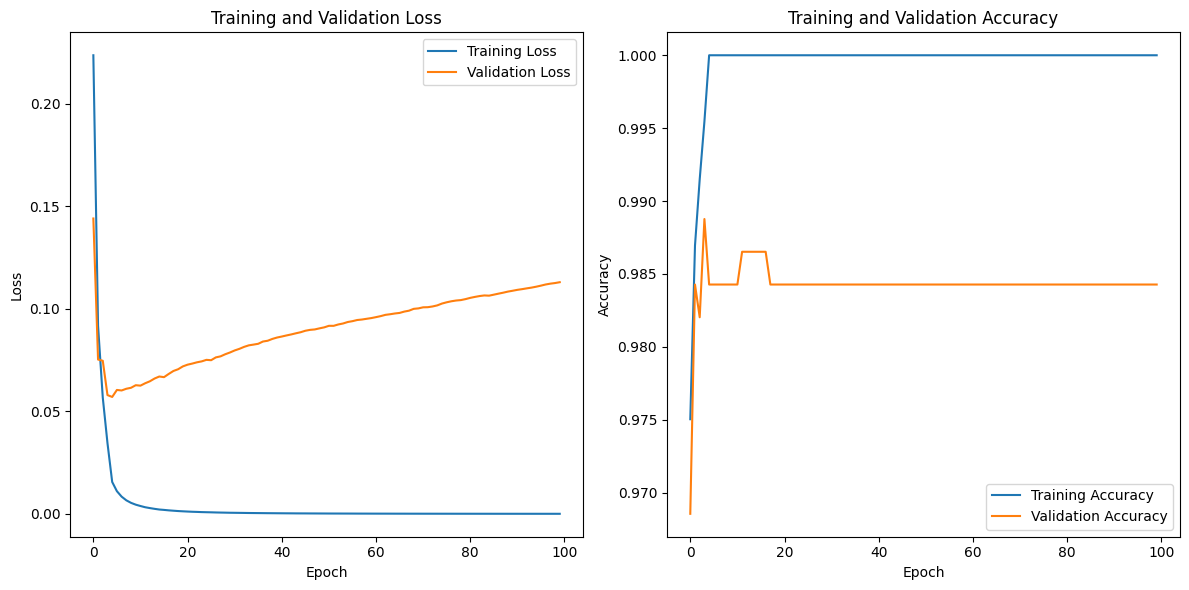

In [46]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [16]:
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss", test_loss)
print("Test Accuracy", test_accuracy)

1/1 [==============================] - 0s 464ms/step - loss: 0.3535 - sparse_categorical_accuracy: 1.0000
Test Loss 0.35351499915122986
Test Accuracy 1.0


### Loading the pretrained model

In [17]:
# Load tokenizer and model
tokenizer_fine_tuned = AutoTokenizer.from_pretrained("./results")
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained("./results")


Some layers from the model checkpoint at ./results were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./results and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
test_text = test_texts[5]

In [39]:
test_text

'blair stresses prosperity goals tony blair says his party s next manifesto will be  unremittingly new labour  and aimed at producing  personal prosperity for all .  the prime minister is trying to draw a line under speculation over the state of his relationship with gordon brown with the speech in chatham  kent. he is saying that prosperity means both individual wealth and ensuring  radically improved  public services. he is also claiming labour is more ideologically united than ever. mr brown is currently touring africa after a week of facing questions about reports of his splits with downing street.  with the election widely predicted for may  angry labour mps this week warned mr blair and mr brown about the dangers of disunity. now mr blair is trying to put the focus on the substance of labour s platform for a third term in government. labour made low inflation  unemployment and mortgage rates the centrepiece of a new poster campaign this week.  and on thursday mr blair is saying: 

In [40]:
encoding = tokenizer_fine_tuned(test_text, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [41]:
logits = model_fine_tuned(**encoding).logits

In [42]:
predicted_class = tf.argmax(logits, axis=-1).numpy()[0]
print("predicted_class:", predicted_class)

predicted_class: 2


In [43]:
test_labels[5]

2